# Imaging and structure analysis of ferroelectric domains, domain walls, and vortices by scanning electron diffraction

Ursula Ludacka<sup>1</sup>, Jiali He<sup>1</sup>, Shuyu Qin<sup>3,4</sup>, Manuel Zahn<sup>1,5</sup>, Emil Frang Christiansen<sup>2</sup>, Kasper A. Hunnestad<sup>1</sup>, Zewu Yan<sup>6,7</sup>, Edith Bourret<sup>7</sup>, István Kézsmárki<sup>5</sup>, Antonius T. J. van Helvoort<sup>2</sup>, Joshua Agar<sup>3,4</sup>, Dennis Meier<sup>1</sup>

Email: dennis.meier@ntnu.no, jca92@drexel.edu

<sup>1</sup> Department of Materials Science and Engineering, NTNU Norwegian University of Science and Technology, Trondheim, Norway \
<sup>2</sup> Department of Physics, NTNU Norwegian University of Science and Technology, Trondheim, Norway\
<sup>3</sup> Department of Materials Science and Engineering, Lehigh University, Bethlehem, USA\
<sup>4</sup> Department of Mechanical Engineering and Mechanics, Drexel University, Philadelphia, USA\
<sup>5</sup> Experimental Physics V, University of Augsburg, Augsburg, Germany\
<sup>6</sup> Department of Physics, ETH Zurich, Zürich, Switzerland.\
<sup>7</sup> Materials Sciences Division, Lawrence Berkeley National Laboratory, Berkeley, USA.


## Abstract

Direct electron detectors in scanning transmission electron microscopy give unprecedented possibilities for structure analysis at the nanoscale. In electronic and quantum materials, this new capability gives access to, for example, emergent chiral structures and symmetry-breaking distortions that underpin functional properties. Quantifying nanoscale structural features with statistical significance, however, is complicated by the subtleties of dynamic diffraction and coexisting contrast mechanisms, which often results in low signal-to-noise and the superposition of multiple signals that are challenging to deconvolute. Here we apply scanning electron diffraction to explore local polar distortions in the uniaxial ferroelectric Er(Mn,Ti)O3. Using a custom-designed convolutional autoencoder with bespoke regularization, we demonstrate that subtle variations in the scattering signatures of ferroelectric domains, domain walls, and vortex textures can readily be disentangled with statistical significance and separated from extrinsic contributions due to, e.g., variations in specimen thickness or bending. The work demonstrates a pathway to quantitatively measure symmetry-breaking distortions across large areas, mapping structural changes at interfaces and topological structures with nanoscale spatial resolution.


$$ L = \frac{\lambda}{2N} \sum\limits_{i=1}^{N} \left[\left(\sum\limits_{j=1, j\neq i}^{N} \frac{latent_i \cdot latent_j}{\left\lVert latent_i \right\rVert \left\lVert latent_j \right\rVert}\right] - 1\right)$$

## Imports and settings

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch

from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import layout_fig, imagemap, labelfigs, scalebar
from m3_learning.viz.Movies import make_movie
from m3_learning.nn.STEM_AE.Dataset import STEM_Dataset
printing = printer(basepath='./figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline



printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42


2023-04-13 17:46:16.815132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 17:46:16.934358: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-13 17:46:17.377870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/cv2/../../lib64:
2023-04-13 17:46:17.377921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'lib

tensorflow seed was set to 42


TODO: add download


## Loads the Dataset

In [2]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
domain = STEM_Dataset(data_path="/home/ferroelectric/data/256p_3w_step1k4_a5_cl12_50ms_nmf_4.hspy")

/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


## Instantiates the Visualizer

In [12]:
# instantiates the visualization class
viz = Viz(printer = printing, labelfigs_=True)
viz.scalebar_ = {'width': 250, 'scale length': 100, 'units': 'nm', 'channel': -1}


## Visualizes the Raw Data

./figures/STEM_raw_and_virtual_domain.png
./figures/STEM_raw_and_virtual_domain.svg


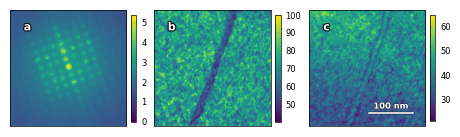

In [5]:
bright_field_ = (117,135, 119, 135)
dark_field_ = (102,117, 114,130)
printer_ = printer(basepath="./figures/")
filename = "STEM_raw_and_virtual_domain"
viz.STEM_raw_and_virtual(domain, bright_field_=bright_field_, dark_field_=dark_field_, scalebar_=True, filename=filename, shape_ = domain.data.shape)

## Builds the Neural Network Model

In [5]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:1'

model = ConvAutoencoder(encoder_step_size=encoder_step_size,
                        pooling_list=pooling_list,
                        decoder_step_size=decoder_step_size,
                        upsampling_list=upsampling_list,
                        embedding_size=embedding_size,
                        conv_size=conv_size,
                        device=device,
                        learning_rate=3e-5)

## Trains or Loads Pretrained Weights

In [6]:
# set retrain parameter
train = False

if train:
    model.Train(domain.log_data,
          coef_1=1e-5,
          epochs=225,
          with_scheduler=False,
          folder_path="Domain_Weights",
          batch_size=256)
else:
    model.load_weights("/home/ferroelectric/data/11.23_log_epoch_0376_coef_1e-05_trainloss_0.1362.pkl")

## Computes the Embeddings

In [7]:
embedding = model.get_embedding(domain.log_data)


100%|██████████| 2048/2048 [04:10<00:00,  8.16it/s]


## Visualizes the Embeddings

(5, 8)
./figures/domain wall_embedding_maps.png
./figures/domain wall_embedding_maps.svg


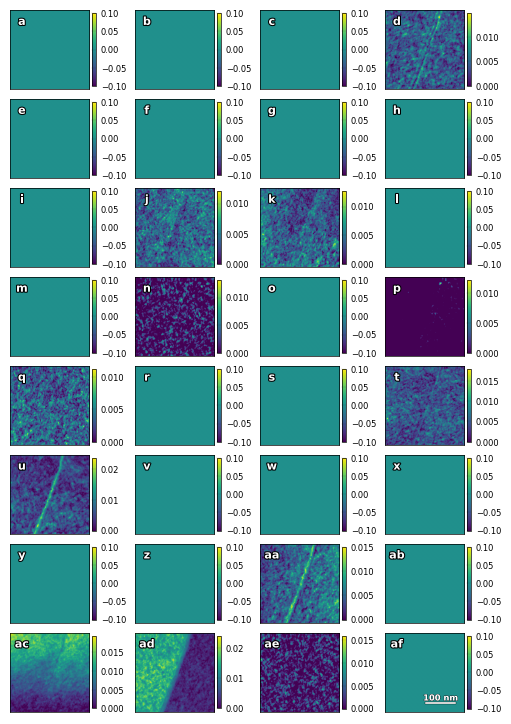

In [13]:
# add one scalebar

viz.scalebar_ = {'width': 250, 'scale length': 100, 'units': 'nm'}
viz.model = model
viz.embeddings(mod = 4, scalebar_=viz.scalebar_, name = "domain wall", shape_=domain.data.shape, figsize = (5, 8))

## Generates Data from the Latent Space

In [14]:
model.embedding = embedding
viz.model = model
viz.channels = [20,29]
ranges=[[0,0.018],[0,0.022]]
folder_name = 'Generator_of_Figure_4_a_d'

viz.generator_images(ranges = ranges, folder_name = folder_name, figsize=(5, 1.25), cbar_number_format = "%d", shape_=domain.data.shape, divider_ = False)

  0%|          | 0/200 [00:00<?, ?it/s]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.svg


  0%|          | 1/200 [00:01<03:34,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.svg


  1%|          | 2/200 [00:02<03:31,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.svg


  2%|▏         | 3/200 [00:03<03:31,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.svg


  2%|▏         | 4/200 [00:04<03:30,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.svg


  2%|▎         | 5/200 [00:05<03:48,  1.17s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0005_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0005_maps.svg


  3%|▎         | 6/200 [00:06<03:41,  1.14s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0006_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0006_maps.svg


  4%|▎         | 7/200 [00:07<03:36,  1.12s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0007_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0007_maps.svg


  4%|▍         | 8/200 [00:08<03:32,  1.11s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0008_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0008_maps.svg


  4%|▍         | 9/200 [00:09<03:31,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0009_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0009_maps.svg


  5%|▌         | 10/200 [00:11<03:28,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0010_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0010_maps.svg


  6%|▌         | 11/200 [00:12<03:26,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0011_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0011_maps.svg


  6%|▌         | 12/200 [00:13<03:24,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0012_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0012_maps.svg


  6%|▋         | 13/200 [00:14<03:22,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0013_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0013_maps.svg


  7%|▋         | 14/200 [00:15<03:20,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0014_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0014_maps.svg


  8%|▊         | 15/200 [00:16<03:19,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0015_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0015_maps.svg


  8%|▊         | 16/200 [00:17<03:18,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0016_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0016_maps.svg


  8%|▊         | 17/200 [00:18<03:16,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0017_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0017_maps.svg


  9%|▉         | 18/200 [00:19<03:29,  1.15s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0018_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0018_maps.svg


 10%|▉         | 19/200 [00:20<03:23,  1.13s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0019_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0019_maps.svg


 10%|█         | 20/200 [00:22<03:20,  1.11s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0020_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0020_maps.svg


 10%|█         | 21/200 [00:23<03:16,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0021_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0021_maps.svg


 11%|█         | 22/200 [00:24<03:14,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0022_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0022_maps.svg


 12%|█▏        | 23/200 [00:25<03:13,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0023_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0023_maps.svg


 12%|█▏        | 24/200 [00:26<03:11,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0024_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0024_maps.svg


 12%|█▎        | 25/200 [00:27<03:10,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0025_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0025_maps.svg


 13%|█▎        | 26/200 [00:28<03:08,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0026_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0026_maps.svg


 14%|█▎        | 27/200 [00:29<03:07,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0027_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0027_maps.svg


 14%|█▍        | 28/200 [00:30<03:05,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0028_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0028_maps.svg


 14%|█▍        | 29/200 [00:31<03:04,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0029_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0029_maps.svg


 15%|█▌        | 30/200 [00:32<03:04,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0030_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0030_maps.svg


 16%|█▌        | 31/200 [00:33<03:02,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0031_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0031_maps.svg


 16%|█▌        | 32/200 [00:34<03:00,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0032_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0032_maps.svg


 16%|█▋        | 33/200 [00:36<02:59,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0033_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0033_maps.svg


 17%|█▋        | 34/200 [00:37<03:12,  1.16s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0034_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0034_maps.svg


 18%|█▊        | 35/200 [00:38<03:07,  1.13s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0035_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0035_maps.svg


 18%|█▊        | 36/200 [00:39<03:02,  1.11s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0036_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0036_maps.svg


 18%|█▊        | 37/200 [00:40<02:58,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0037_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0037_maps.svg


 19%|█▉        | 38/200 [00:41<02:56,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0038_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0038_maps.svg


 20%|█▉        | 39/200 [00:42<02:54,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0039_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0039_maps.svg


 20%|██        | 40/200 [00:43<02:52,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0040_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0040_maps.svg


 20%|██        | 41/200 [00:44<02:50,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0041_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0041_maps.svg


 21%|██        | 42/200 [00:45<02:49,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0042_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0042_maps.svg


 22%|██▏       | 43/200 [00:47<02:47,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0043_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0043_maps.svg


 22%|██▏       | 44/200 [00:48<02:47,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0044_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0044_maps.svg


 22%|██▎       | 45/200 [00:49<02:46,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0045_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0045_maps.svg


 23%|██▎       | 46/200 [00:50<02:45,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0046_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0046_maps.svg


 24%|██▎       | 47/200 [00:51<02:44,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0047_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0047_maps.svg


 24%|██▍       | 48/200 [00:52<02:42,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0048_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0048_maps.svg


 24%|██▍       | 49/200 [00:53<02:41,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0049_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0049_maps.svg


 25%|██▌       | 50/200 [00:54<02:40,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0050_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0050_maps.svg


 26%|██▌       | 51/200 [00:55<02:39,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0051_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0051_maps.svg


 26%|██▌       | 52/200 [00:56<02:38,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0052_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0052_maps.svg


 26%|██▋       | 53/200 [00:57<02:37,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0053_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0053_maps.svg


 27%|██▋       | 54/200 [00:59<02:52,  1.18s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0054_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0054_maps.svg


 28%|██▊       | 55/200 [01:00<02:46,  1.15s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0055_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0055_maps.svg


 28%|██▊       | 56/200 [01:01<02:41,  1.12s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0056_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0056_maps.svg


 28%|██▊       | 57/200 [01:02<02:39,  1.11s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0057_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0057_maps.svg


 29%|██▉       | 58/200 [01:03<02:40,  1.13s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0058_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0058_maps.svg


 30%|██▉       | 59/200 [01:04<02:36,  1.11s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0059_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0059_maps.svg


 30%|███       | 60/200 [01:05<02:34,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0060_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0060_maps.svg


 30%|███       | 61/200 [01:06<02:31,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0061_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0061_maps.svg


 31%|███       | 62/200 [01:07<02:30,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0062_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0062_maps.svg


 32%|███▏      | 63/200 [01:08<02:28,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0063_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0063_maps.svg


 32%|███▏      | 64/200 [01:10<02:27,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0064_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0064_maps.svg


 32%|███▎      | 65/200 [01:11<02:25,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0065_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0065_maps.svg


 33%|███▎      | 66/200 [01:12<02:24,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0066_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0066_maps.svg


 34%|███▎      | 67/200 [01:13<02:23,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0067_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0067_maps.svg


 34%|███▍      | 68/200 [01:14<02:21,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0068_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0068_maps.svg


 34%|███▍      | 69/200 [01:15<02:20,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0069_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0069_maps.svg


 35%|███▌      | 70/200 [01:16<02:18,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0070_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0070_maps.svg


 36%|███▌      | 71/200 [01:17<02:17,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0071_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0071_maps.svg


 36%|███▌      | 72/200 [01:18<02:16,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0072_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0072_maps.svg


 36%|███▋      | 73/200 [01:19<02:15,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0073_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0073_maps.svg


 37%|███▋      | 74/200 [01:20<02:15,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0074_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0074_maps.svg


 38%|███▊      | 75/200 [01:21<02:13,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0075_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0075_maps.svg


 38%|███▊      | 76/200 [01:22<02:12,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0076_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0076_maps.svg


 38%|███▊      | 77/200 [01:23<02:11,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0077_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0077_maps.svg


 39%|███▉      | 78/200 [01:25<02:26,  1.20s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0078_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0078_maps.svg


 40%|███▉      | 79/200 [01:26<02:20,  1.16s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0079_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0079_maps.svg


 40%|████      | 80/200 [01:27<02:16,  1.14s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0080_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0080_maps.svg


 40%|████      | 81/200 [01:28<02:12,  1.12s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0081_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0081_maps.svg


 41%|████      | 82/200 [01:29<02:10,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0082_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0082_maps.svg


 42%|████▏     | 83/200 [01:30<02:08,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0083_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0083_maps.svg


 42%|████▏     | 84/200 [01:31<02:06,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0084_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0084_maps.svg


 42%|████▎     | 85/200 [01:32<02:04,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0085_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0085_maps.svg


 43%|████▎     | 86/200 [01:34<02:03,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0086_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0086_maps.svg


 44%|████▎     | 87/200 [01:35<02:02,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0087_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0087_maps.svg


 44%|████▍     | 88/200 [01:36<02:01,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0088_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0088_maps.svg


 44%|████▍     | 89/200 [01:37<01:59,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0089_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0089_maps.svg


 45%|████▌     | 90/200 [01:38<01:58,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0090_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0090_maps.svg


 46%|████▌     | 91/200 [01:39<01:57,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0091_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0091_maps.svg


 46%|████▌     | 92/200 [01:40<01:56,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0092_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0092_maps.svg


 46%|████▋     | 93/200 [01:41<01:55,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0093_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0093_maps.svg


 47%|████▋     | 94/200 [01:42<01:53,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0094_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0094_maps.svg


 48%|████▊     | 95/200 [01:43<01:52,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0095_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0095_maps.svg


 48%|████▊     | 96/200 [01:44<01:51,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0096_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0096_maps.svg


 48%|████▊     | 97/200 [01:45<01:50,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0097_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0097_maps.svg


 49%|████▉     | 98/200 [01:46<01:49,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0098_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0098_maps.svg


 50%|████▉     | 99/200 [01:47<01:48,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0099_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0099_maps.svg


 50%|█████     | 100/200 [01:49<01:47,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0100_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0100_maps.svg


 50%|█████     | 101/200 [01:50<01:46,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0101_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0101_maps.svg


 51%|█████     | 102/200 [01:51<01:44,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0102_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0102_maps.svg


 52%|█████▏    | 103/200 [01:52<01:43,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0103_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0103_maps.svg


 52%|█████▏    | 104/200 [01:53<01:42,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0104_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0104_maps.svg


 52%|█████▎    | 105/200 [01:54<01:41,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0105_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0105_maps.svg


 53%|█████▎    | 106/200 [01:55<01:40,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0106_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0106_maps.svg


 54%|█████▎    | 107/200 [01:56<01:39,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0107_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0107_maps.svg


 54%|█████▍    | 108/200 [01:57<01:38,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0108_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0108_maps.svg


 55%|█████▍    | 109/200 [01:59<01:53,  1.24s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0109_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0109_maps.svg


 55%|█████▌    | 110/200 [02:00<01:47,  1.19s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0110_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0110_maps.svg


 56%|█████▌    | 111/200 [02:01<01:43,  1.16s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0111_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0111_maps.svg


 56%|█████▌    | 112/200 [02:02<01:39,  1.14s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0112_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0112_maps.svg


 56%|█████▋    | 113/200 [02:03<01:37,  1.12s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0113_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0113_maps.svg


 57%|█████▋    | 114/200 [02:04<01:34,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0114_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0114_maps.svg


 57%|█████▊    | 115/200 [02:05<01:32,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0115_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0115_maps.svg


 58%|█████▊    | 116/200 [02:06<01:31,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0116_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0116_maps.svg


 58%|█████▊    | 117/200 [02:07<01:29,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0117_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0117_maps.svg


 59%|█████▉    | 118/200 [02:08<01:28,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0118_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0118_maps.svg


 60%|█████▉    | 119/200 [02:10<01:27,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0119_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0119_maps.svg


 60%|██████    | 120/200 [02:11<01:26,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0120_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0120_maps.svg


 60%|██████    | 121/200 [02:12<01:25,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0121_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0121_maps.svg


 61%|██████    | 122/200 [02:13<01:24,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0122_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0122_maps.svg


 62%|██████▏   | 123/200 [02:14<01:22,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0123_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0123_maps.svg


 62%|██████▏   | 124/200 [02:15<01:21,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0124_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0124_maps.svg


 62%|██████▎   | 125/200 [02:16<01:20,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0125_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0125_maps.svg


 63%|██████▎   | 126/200 [02:17<01:19,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0126_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0126_maps.svg


 64%|██████▎   | 127/200 [02:18<01:18,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0127_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0127_maps.svg


 64%|██████▍   | 128/200 [02:19<01:17,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0128_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0128_maps.svg


 64%|██████▍   | 129/200 [02:20<01:16,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0129_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0129_maps.svg


 65%|██████▌   | 130/200 [02:21<01:15,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0130_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0130_maps.svg


 66%|██████▌   | 131/200 [02:22<01:14,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0131_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0131_maps.svg


 66%|██████▌   | 132/200 [02:23<01:13,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0132_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0132_maps.svg


 66%|██████▋   | 133/200 [02:25<01:12,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0133_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0133_maps.svg


 67%|██████▋   | 134/200 [02:26<01:10,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0134_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0134_maps.svg


 68%|██████▊   | 135/200 [02:27<01:09,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0135_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0135_maps.svg


 68%|██████▊   | 136/200 [02:28<01:08,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0136_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0136_maps.svg


 68%|██████▊   | 137/200 [02:29<01:07,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0137_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0137_maps.svg


 69%|██████▉   | 138/200 [02:30<01:06,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0138_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0138_maps.svg


 70%|██████▉   | 139/200 [02:31<01:05,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0139_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0139_maps.svg


 70%|███████   | 140/200 [02:32<01:04,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0140_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0140_maps.svg


 70%|███████   | 141/200 [02:33<01:03,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0141_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0141_maps.svg


 71%|███████   | 142/200 [02:34<01:02,  1.07s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0142_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0142_maps.svg


 72%|███████▏  | 143/200 [02:35<01:01,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0143_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0143_maps.svg


 72%|███████▏  | 144/200 [02:36<01:00,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0144_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0144_maps.svg


 72%|███████▎  | 145/200 [02:37<00:59,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0145_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0145_maps.svg


 73%|███████▎  | 146/200 [02:39<00:58,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0146_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0146_maps.svg


 74%|███████▎  | 147/200 [02:40<01:08,  1.29s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0147_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0147_maps.svg


 74%|███████▍  | 148/200 [02:41<01:03,  1.22s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0148_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0148_maps.svg


 74%|███████▍  | 149/200 [02:42<00:59,  1.18s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0149_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0149_maps.svg


 75%|███████▌  | 150/200 [02:44<00:57,  1.15s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0150_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0150_maps.svg


 76%|███████▌  | 151/200 [02:45<00:55,  1.13s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0151_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0151_maps.svg


 76%|███████▌  | 152/200 [02:46<00:53,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0152_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0152_maps.svg


 76%|███████▋  | 153/200 [02:47<00:51,  1.10s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0153_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0153_maps.svg


 77%|███████▋  | 154/200 [02:48<00:50,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0154_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0154_maps.svg


 78%|███████▊  | 155/200 [02:49<00:48,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0155_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0155_maps.svg


 78%|███████▊  | 156/200 [02:50<00:47,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0156_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0156_maps.svg


 78%|███████▊  | 157/200 [02:51<00:46,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0157_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0157_maps.svg


 79%|███████▉  | 158/200 [02:52<00:45,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0158_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0158_maps.svg


 80%|███████▉  | 159/200 [02:53<00:44,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0159_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0159_maps.svg


 80%|████████  | 160/200 [02:54<00:43,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0160_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0160_maps.svg


 80%|████████  | 161/200 [02:55<00:42,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0161_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0161_maps.svg


 81%|████████  | 162/200 [02:56<00:41,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0162_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0162_maps.svg


 82%|████████▏ | 163/200 [02:58<00:40,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0163_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0163_maps.svg


 82%|████████▏ | 164/200 [02:59<00:39,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0164_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0164_maps.svg


 82%|████████▎ | 165/200 [03:00<00:38,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0165_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0165_maps.svg


 83%|████████▎ | 166/200 [03:01<00:36,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0166_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0166_maps.svg


 84%|████████▎ | 167/200 [03:02<00:35,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0167_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0167_maps.svg


 84%|████████▍ | 168/200 [03:03<00:34,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0168_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0168_maps.svg


 84%|████████▍ | 169/200 [03:04<00:33,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0169_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0169_maps.svg


 85%|████████▌ | 170/200 [03:05<00:32,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0170_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0170_maps.svg


 86%|████████▌ | 171/200 [03:06<00:31,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0171_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0171_maps.svg


 86%|████████▌ | 172/200 [03:07<00:30,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0172_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0172_maps.svg


 86%|████████▋ | 173/200 [03:08<00:29,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0173_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0173_maps.svg


 87%|████████▋ | 174/200 [03:09<00:28,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0174_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0174_maps.svg


 88%|████████▊ | 175/200 [03:11<00:27,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0175_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0175_maps.svg


 88%|████████▊ | 176/200 [03:12<00:25,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0176_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0176_maps.svg


 88%|████████▊ | 177/200 [03:13<00:24,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0177_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0177_maps.svg


 89%|████████▉ | 178/200 [03:14<00:23,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0178_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0178_maps.svg


 90%|████████▉ | 179/200 [03:15<00:22,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0179_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0179_maps.svg


 90%|█████████ | 180/200 [03:16<00:21,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0180_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0180_maps.svg


 90%|█████████ | 181/200 [03:17<00:20,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0181_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0181_maps.svg


 91%|█████████ | 182/200 [03:18<00:19,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0182_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0182_maps.svg


 92%|█████████▏| 183/200 [03:19<00:18,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0183_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0183_maps.svg


 92%|█████████▏| 184/200 [03:20<00:17,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0184_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0184_maps.svg


 92%|█████████▎| 185/200 [03:21<00:16,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0185_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0185_maps.svg


 93%|█████████▎| 186/200 [03:22<00:15,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0186_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0186_maps.svg


 94%|█████████▎| 187/200 [03:23<00:14,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0187_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0187_maps.svg


 94%|█████████▍| 188/200 [03:25<00:13,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0188_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0188_maps.svg


 94%|█████████▍| 189/200 [03:26<00:11,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0189_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0189_maps.svg


 95%|█████████▌| 190/200 [03:27<00:10,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0190_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0190_maps.svg


 96%|█████████▌| 191/200 [03:28<00:09,  1.09s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0191_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0191_maps.svg


 96%|█████████▌| 192/200 [03:29<00:08,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0192_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0192_maps.svg


 96%|█████████▋| 193/200 [03:30<00:07,  1.08s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0193_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0193_maps.svg


 97%|█████████▋| 194/200 [03:32<00:08,  1.34s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0194_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0194_maps.svg


 98%|█████████▊| 195/200 [03:33<00:06,  1.26s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0195_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0195_maps.svg


 98%|█████████▊| 196/200 [03:34<00:04,  1.20s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0196_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0196_maps.svg


 98%|█████████▊| 197/200 [03:35<00:03,  1.17s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0197_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0197_maps.svg


 99%|█████████▉| 198/200 [03:36<00:02,  1.14s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0198_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0198_maps.svg


100%|█████████▉| 199/200 [03:37<00:01,  1.12s/it]

(5, 1.25)
./figures/generator_images_Generator_of_Figure_4_a_d/0199_maps.png
./figures/generator_images_Generator_of_Figure_4_a_d/0199_maps.svg


100%|██████████| 200/200 [03:38<00:00,  1.09s/it]


## Builds a Movie

In [13]:
folder = "./figures/generator_images_Generator_of_Figure_4_a_d"
output_folder = "./movies/"

# function to make the movie
make_movie('Domain Wall Generator',
           folder,
           output_folder,
          'png',
          3)

## Vortex Domains

In [6]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
vortex = STEM_Dataset(data_path="/home/ferroelectric/data/SED_256x256x12_30x30_alpha3_NBD_spot0p5nm_CL12cm_vortex.hspy")

/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [7]:
# instantiates the visualization class
viz = Viz(printer = printing, labelfigs_=True)

./figures/STEM_raw_and_virtual_vortex_domains.png
./figures/STEM_raw_and_virtual_vortex_domains.svg


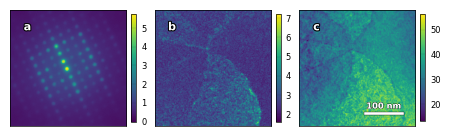

In [8]:
bright_field_ = (150, 162, 152, 165)
dark_field_ = (106,123, 110,125)
printer_ = printer(basepath="./figures/")
filename = "STEM_raw_and_virtual_vortex_domains"
viz.scalebar_ = {'width': 291, 'scale length': 100, 'units': 'nm'}
viz.STEM_raw_and_virtual(vortex, bright_field_=bright_field_, dark_field_=dark_field_, scalebar_=True, filename=filename, shape_ = vortex.data.shape)

## Builds the Neural Network Model

In [9]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:1'

model = ConvAutoencoder(encoder_step_size=encoder_step_size,
                        pooling_list=pooling_list,
                        decoder_step_size=decoder_step_size,
                        upsampling_list=upsampling_list,
                        embedding_size=embedding_size,
                        conv_size=conv_size,
                        device=device,
                        learning_rate=3e-5)

## Trains or Loads Pretrained Weights

In [10]:
# set retrain parameter
train = False

if train:
    model.Train(vortex.log_data,
          coef_1=1e-5,
          epochs=225,
          with_scheduler=False,
          folder_path="vortex_domains_Weights",
          batch_size=256)
    
    model.Train(vortex.log_data,
          max_learning_rate = 5e-5,
          coef_1=5e-4,
          epochs=286,
          epoch_=224,
          with_scheduler=True,
          folder_path="vortex_domains_Weights",
          batch_size=256)
else:
    model.load_weights("/home/ferroelectric/data/4.5_log_epoch_0285_L1loss_0.0001__lr_0.00003_trainloss_0.2279.pkl")

## Computes the Embeddings

In [11]:
embedding = model.get_embedding(vortex.log_data)


100%|██████████| 2048/2048 [04:07<00:00,  8.26it/s]


## Visualizes the Embeddings

./figures/vortex_domains_embedding_maps.png
./figures/vortex_domains_embedding_maps.svg


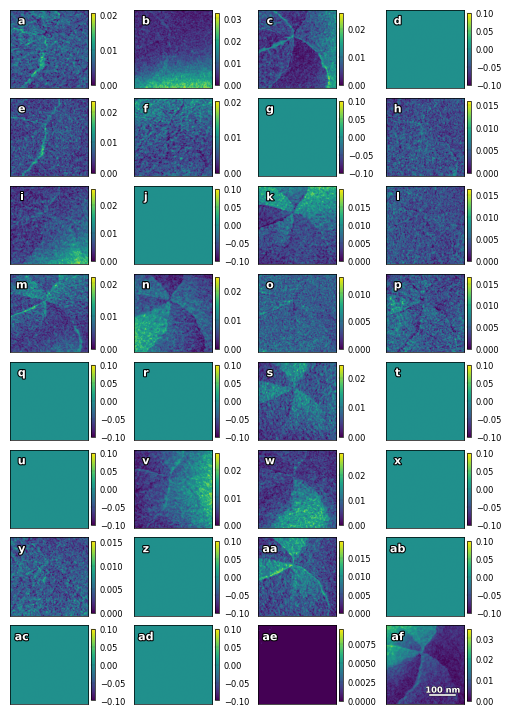

In [12]:
viz.model = model
viz.scalebar_ = {'width': 291, 'scale length': 100, 'units': 'nm'}
viz.embeddings(mod = 4, scalebar_=True, figsize = (5, 8), name = "vortex_domains", shape_=vortex.data.shape)

In [13]:
model.embedding = embedding
viz.model = model
viz.channels=[13,31]
ranges=[[0,0.0225],[0,0.03]]
folder_name = 'Generator_of_Figure_4_vortex_domains'

viz.generator_images(ranges = ranges, folder_name = folder_name, figsize=(5, 1.25), cbar_number_format = "%d", shape_=vortex.data.shape, divider_ = False)

  0%|          | 0/200 [00:00<?, ?it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0000_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0000_maps.svg


  0%|          | 1/200 [00:01<04:04,  1.23s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0001_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0001_maps.svg


  1%|          | 2/200 [00:02<03:35,  1.09s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0002_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0002_maps.svg


  2%|▏         | 3/200 [00:03<03:24,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0003_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0003_maps.svg


  2%|▏         | 4/200 [00:04<03:19,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0004_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0004_maps.svg


  2%|▎         | 5/200 [00:05<03:15,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0005_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0005_maps.svg


  3%|▎         | 6/200 [00:06<03:13,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0006_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0006_maps.svg


  4%|▎         | 7/200 [00:07<03:11,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0007_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0007_maps.svg


  4%|▍         | 8/200 [00:08<03:10,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0008_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0008_maps.svg


  4%|▍         | 9/200 [00:09<03:08,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0009_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0009_maps.svg


  5%|▌         | 10/200 [00:10<03:07,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0010_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0010_maps.svg


  6%|▌         | 11/200 [00:11<03:17,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0011_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0011_maps.svg


  6%|▌         | 12/200 [00:12<03:12,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0012_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0012_maps.svg


  6%|▋         | 13/200 [00:13<03:09,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0013_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0013_maps.svg


  7%|▋         | 14/200 [00:14<03:07,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0014_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0014_maps.svg


  8%|▊         | 15/200 [00:15<03:05,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0015_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0015_maps.svg


  8%|▊         | 16/200 [00:16<03:03,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0016_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0016_maps.svg


  8%|▊         | 17/200 [00:17<03:01,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0017_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0017_maps.svg


  9%|▉         | 18/200 [00:18<03:00,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0018_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0018_maps.svg


 10%|▉         | 19/200 [00:19<02:58,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0019_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0019_maps.svg


 10%|█         | 20/200 [00:20<02:57,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0020_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0020_maps.svg


 10%|█         | 21/200 [00:21<02:56,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0021_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0021_maps.svg


 11%|█         | 22/200 [00:22<02:55,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0022_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0022_maps.svg


 12%|█▏        | 23/200 [00:23<03:06,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0023_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0023_maps.svg


 12%|█▏        | 24/200 [00:24<03:02,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0024_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0024_maps.svg


 12%|█▎        | 25/200 [00:25<02:58,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0025_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0025_maps.svg


 13%|█▎        | 26/200 [00:26<02:55,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0026_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0026_maps.svg


 14%|█▎        | 27/200 [00:27<02:53,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0027_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0027_maps.svg


 14%|█▍        | 28/200 [00:28<02:51,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0028_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0028_maps.svg


 14%|█▍        | 29/200 [00:29<02:49,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0029_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0029_maps.svg


 15%|█▌        | 30/200 [00:30<02:48,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0030_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0030_maps.svg


 16%|█▌        | 31/200 [00:31<02:47,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0031_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0031_maps.svg


 16%|█▌        | 32/200 [00:32<02:45,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0032_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0032_maps.svg


 16%|█▋        | 33/200 [00:33<02:44,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0033_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0033_maps.svg


 17%|█▋        | 34/200 [00:34<02:43,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0034_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0034_maps.svg


 18%|█▊        | 35/200 [00:35<02:42,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0035_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0035_maps.svg


 18%|█▊        | 36/200 [00:36<02:41,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0036_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0036_maps.svg


 18%|█▊        | 37/200 [00:37<02:40,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0037_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0037_maps.svg


 19%|█▉        | 38/200 [00:38<02:53,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0038_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0038_maps.svg


 20%|█▉        | 39/200 [00:39<02:47,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0039_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0039_maps.svg


 20%|██        | 40/200 [00:40<02:44,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0040_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0040_maps.svg


 20%|██        | 41/200 [00:41<02:41,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0041_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0041_maps.svg


 21%|██        | 42/200 [00:42<02:38,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0042_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0042_maps.svg


 22%|██▏       | 43/200 [00:43<02:36,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0043_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0043_maps.svg


 22%|██▏       | 44/200 [00:44<02:35,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0044_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0044_maps.svg


 22%|██▎       | 45/200 [00:45<02:33,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0045_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0045_maps.svg


 23%|██▎       | 46/200 [00:46<02:32,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0046_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0046_maps.svg


 24%|██▎       | 47/200 [00:47<02:31,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0047_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0047_maps.svg


 24%|██▍       | 48/200 [00:48<02:29,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0048_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0048_maps.svg


 24%|██▍       | 49/200 [00:49<02:28,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0049_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0049_maps.svg


 25%|██▌       | 50/200 [00:50<02:27,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0050_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0050_maps.svg


 26%|██▌       | 51/200 [00:51<02:26,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0051_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0051_maps.svg


 26%|██▌       | 52/200 [00:52<02:25,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0052_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0052_maps.svg


 26%|██▋       | 53/200 [00:53<02:24,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0053_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0053_maps.svg


 27%|██▋       | 54/200 [00:54<02:23,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0054_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0054_maps.svg


 28%|██▊       | 55/200 [00:55<02:22,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0055_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0055_maps.svg


 28%|██▊       | 56/200 [00:56<02:36,  1.09s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0056_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0056_maps.svg


 28%|██▊       | 57/200 [00:57<02:31,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0057_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0057_maps.svg


 29%|██▉       | 58/200 [00:58<02:27,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0058_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0058_maps.svg


 30%|██▉       | 59/200 [00:59<02:23,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0059_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0059_maps.svg


 30%|███       | 60/200 [01:00<02:21,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0060_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0060_maps.svg


 30%|███       | 61/200 [01:01<02:19,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0061_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0061_maps.svg


 31%|███       | 62/200 [01:02<02:17,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0062_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0062_maps.svg


 32%|███▏      | 63/200 [01:03<02:15,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0063_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0063_maps.svg


 32%|███▏      | 64/200 [01:04<02:14,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0064_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0064_maps.svg


 32%|███▎      | 65/200 [01:05<02:13,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0065_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0065_maps.svg


 33%|███▎      | 66/200 [01:06<02:12,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0066_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0066_maps.svg


 34%|███▎      | 67/200 [01:07<02:11,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0067_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0067_maps.svg


 34%|███▍      | 68/200 [01:08<02:10,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0068_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0068_maps.svg


 34%|███▍      | 69/200 [01:09<02:09,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0069_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0069_maps.svg


 35%|███▌      | 70/200 [01:10<02:08,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0070_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0070_maps.svg


 36%|███▌      | 71/200 [01:11<02:07,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0071_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0071_maps.svg


 36%|███▌      | 72/200 [01:12<02:06,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0072_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0072_maps.svg


 36%|███▋      | 73/200 [01:13<02:05,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0073_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0073_maps.svg


 37%|███▋      | 74/200 [01:14<02:04,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0074_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0074_maps.svg


 38%|███▊      | 75/200 [01:15<02:03,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0075_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0075_maps.svg


 38%|███▊      | 76/200 [01:16<02:02,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0076_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0076_maps.svg


 38%|███▊      | 77/200 [01:17<02:01,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0077_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0077_maps.svg


 39%|███▉      | 78/200 [01:18<02:00,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0078_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0078_maps.svg


 40%|███▉      | 79/200 [01:19<02:14,  1.11s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0079_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0079_maps.svg


 40%|████      | 80/200 [01:20<02:09,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0080_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0080_maps.svg


 40%|████      | 81/200 [01:21<02:04,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0081_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0081_maps.svg


 41%|████      | 82/200 [01:22<02:01,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0082_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0082_maps.svg


 42%|████▏     | 83/200 [01:23<01:58,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0083_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0083_maps.svg


 42%|████▏     | 84/200 [01:24<01:56,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0084_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0084_maps.svg


 42%|████▎     | 85/200 [01:25<01:55,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0085_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0085_maps.svg


 43%|████▎     | 86/200 [01:26<01:53,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0086_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0086_maps.svg


 44%|████▎     | 87/200 [01:27<01:52,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0087_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0087_maps.svg


 44%|████▍     | 88/200 [01:28<01:51,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0088_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0088_maps.svg


 44%|████▍     | 89/200 [01:29<01:49,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0089_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0089_maps.svg


 45%|████▌     | 90/200 [01:30<01:48,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0090_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0090_maps.svg


 46%|████▌     | 91/200 [01:31<01:47,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0091_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0091_maps.svg


 46%|████▌     | 92/200 [01:32<01:46,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0092_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0092_maps.svg


 46%|████▋     | 93/200 [01:33<01:45,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0093_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0093_maps.svg


 47%|████▋     | 94/200 [01:34<01:44,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0094_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0094_maps.svg


 48%|████▊     | 95/200 [01:35<01:43,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0095_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0095_maps.svg


 48%|████▊     | 96/200 [01:36<01:42,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0096_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0096_maps.svg


 48%|████▊     | 97/200 [01:37<01:41,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0097_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0097_maps.svg


 49%|████▉     | 98/200 [01:38<01:40,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0098_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0098_maps.svg


 50%|████▉     | 99/200 [01:39<01:39,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0099_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0099_maps.svg


 50%|█████     | 100/200 [01:40<01:38,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0100_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0100_maps.svg


 50%|█████     | 101/200 [01:41<01:37,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0101_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0101_maps.svg


 51%|█████     | 102/200 [01:42<01:36,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0102_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0102_maps.svg


 52%|█████▏    | 103/200 [01:43<01:35,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0103_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0103_maps.svg


 52%|█████▏    | 104/200 [01:44<01:34,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0104_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0104_maps.svg


 52%|█████▎    | 105/200 [01:45<01:33,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0105_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0105_maps.svg


 53%|█████▎    | 106/200 [01:46<01:32,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0106_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0106_maps.svg


 54%|█████▎    | 107/200 [01:47<01:46,  1.14s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0107_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0107_maps.svg


 54%|█████▍    | 108/200 [01:48<01:40,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0108_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0108_maps.svg


 55%|█████▍    | 109/200 [01:49<01:36,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0109_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0109_maps.svg


 55%|█████▌    | 110/200 [01:50<01:33,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0110_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0110_maps.svg


 56%|█████▌    | 111/200 [01:51<01:31,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0111_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0111_maps.svg


 56%|█████▌    | 112/200 [01:52<01:29,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0112_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0112_maps.svg


 56%|█████▋    | 113/200 [01:53<01:27,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0113_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0113_maps.svg


 57%|█████▋    | 114/200 [01:54<01:25,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0114_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0114_maps.svg


 57%|█████▊    | 115/200 [01:55<01:24,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0115_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0115_maps.svg


 58%|█████▊    | 116/200 [01:56<01:23,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0116_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0116_maps.svg


 58%|█████▊    | 117/200 [01:57<01:22,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0117_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0117_maps.svg


 59%|█████▉    | 118/200 [01:58<01:21,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0118_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0118_maps.svg


 60%|█████▉    | 119/200 [01:59<01:20,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0119_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0119_maps.svg


 60%|██████    | 120/200 [02:00<01:19,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0120_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0120_maps.svg


 60%|██████    | 121/200 [02:01<01:18,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0121_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0121_maps.svg


 61%|██████    | 122/200 [02:02<01:17,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0122_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0122_maps.svg


 62%|██████▏   | 123/200 [02:03<01:16,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0123_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0123_maps.svg


 62%|██████▏   | 124/200 [02:04<01:15,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0124_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0124_maps.svg


 62%|██████▎   | 125/200 [02:05<01:14,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0125_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0125_maps.svg


 63%|██████▎   | 126/200 [02:06<01:13,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0126_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0126_maps.svg


 64%|██████▎   | 127/200 [02:07<01:12,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0127_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0127_maps.svg


 64%|██████▍   | 128/200 [02:08<01:11,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0128_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0128_maps.svg


 64%|██████▍   | 129/200 [02:09<01:10,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0129_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0129_maps.svg


 65%|██████▌   | 130/200 [02:10<01:09,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0130_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0130_maps.svg


 66%|██████▌   | 131/200 [02:11<01:08,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0131_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0131_maps.svg


 66%|██████▌   | 132/200 [02:12<01:07,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0132_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0132_maps.svg


 66%|██████▋   | 133/200 [02:13<01:06,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0133_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0133_maps.svg


 67%|██████▋   | 134/200 [02:14<01:05,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0134_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0134_maps.svg


 68%|██████▊   | 135/200 [02:15<01:04,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0135_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0135_maps.svg


 68%|██████▊   | 136/200 [02:16<01:03,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0136_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0136_maps.svg


 68%|██████▊   | 137/200 [02:17<01:02,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0137_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0137_maps.svg


 69%|██████▉   | 138/200 [02:18<01:01,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0138_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0138_maps.svg


 70%|██████▉   | 139/200 [02:19<01:00,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0139_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0139_maps.svg


 70%|███████   | 140/200 [02:20<00:59,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0140_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0140_maps.svg


 70%|███████   | 141/200 [02:21<00:58,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0141_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0141_maps.svg


 71%|███████   | 142/200 [02:22<01:08,  1.18s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0142_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0142_maps.svg


 72%|███████▏  | 143/200 [02:23<01:04,  1.12s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0143_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0143_maps.svg


 72%|███████▏  | 144/200 [02:24<01:00,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0144_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0144_maps.svg


 72%|███████▎  | 145/200 [02:25<00:58,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0145_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0145_maps.svg


 73%|███████▎  | 146/200 [02:26<00:55,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0146_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0146_maps.svg


 74%|███████▎  | 147/200 [02:27<00:54,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0147_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0147_maps.svg


 74%|███████▍  | 148/200 [02:28<00:52,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0148_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0148_maps.svg


 74%|███████▍  | 149/200 [02:29<00:51,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0149_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0149_maps.svg


 75%|███████▌  | 150/200 [02:30<00:49,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0150_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0150_maps.svg


 76%|███████▌  | 151/200 [02:31<00:48,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0151_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0151_maps.svg


 76%|███████▌  | 152/200 [02:32<00:47,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0152_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0152_maps.svg


 76%|███████▋  | 153/200 [02:33<00:46,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0153_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0153_maps.svg


 77%|███████▋  | 154/200 [02:34<00:45,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0154_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0154_maps.svg


 78%|███████▊  | 155/200 [02:35<00:44,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0155_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0155_maps.svg


 78%|███████▊  | 156/200 [02:36<00:43,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0156_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0156_maps.svg


 78%|███████▊  | 157/200 [02:37<00:42,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0157_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0157_maps.svg


 79%|███████▉  | 158/200 [02:38<00:41,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0158_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0158_maps.svg


 80%|███████▉  | 159/200 [02:39<00:40,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0159_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0159_maps.svg


 80%|████████  | 160/200 [02:40<00:39,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0160_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0160_maps.svg


 80%|████████  | 161/200 [02:41<00:38,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0161_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0161_maps.svg


 81%|████████  | 162/200 [02:42<00:37,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0162_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0162_maps.svg


 82%|████████▏ | 163/200 [02:43<00:36,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0163_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0163_maps.svg


 82%|████████▏ | 164/200 [02:44<00:35,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0164_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0164_maps.svg


 82%|████████▎ | 165/200 [02:45<00:34,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0165_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0165_maps.svg


 83%|████████▎ | 166/200 [02:46<00:33,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0166_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0166_maps.svg


 84%|████████▎ | 167/200 [02:47<00:32,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0167_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0167_maps.svg


 84%|████████▍ | 168/200 [02:48<00:31,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0168_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0168_maps.svg


 84%|████████▍ | 169/200 [02:49<00:30,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0169_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0169_maps.svg


 85%|████████▌ | 170/200 [02:50<00:29,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0170_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0170_maps.svg


 86%|████████▌ | 171/200 [02:51<00:28,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0171_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0171_maps.svg


 86%|████████▌ | 172/200 [02:52<00:27,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0172_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0172_maps.svg


 86%|████████▋ | 173/200 [02:53<00:26,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0173_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0173_maps.svg


 87%|████████▋ | 174/200 [02:54<00:25,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0174_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0174_maps.svg


 88%|████████▊ | 175/200 [02:55<00:24,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0175_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0175_maps.svg


 88%|████████▊ | 176/200 [02:56<00:23,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0176_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0176_maps.svg


 88%|████████▊ | 177/200 [02:57<00:22,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0177_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0177_maps.svg


 89%|████████▉ | 178/200 [02:58<00:21,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0178_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0178_maps.svg


 90%|████████▉ | 179/200 [02:59<00:20,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0179_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0179_maps.svg


 90%|█████████ | 180/200 [03:00<00:19,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0180_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0180_maps.svg


 90%|█████████ | 181/200 [03:01<00:18,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0181_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0181_maps.svg


 91%|█████████ | 182/200 [03:02<00:17,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0182_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0182_maps.svg


 92%|█████████▏| 183/200 [03:03<00:16,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0183_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0183_maps.svg


 92%|█████████▏| 184/200 [03:04<00:15,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0184_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0184_maps.svg


 92%|█████████▎| 185/200 [03:05<00:14,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0185_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0185_maps.svg


 93%|█████████▎| 186/200 [03:07<00:17,  1.23s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0186_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0186_maps.svg


 94%|█████████▎| 187/200 [03:08<00:15,  1.16s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0187_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0187_maps.svg


 94%|█████████▍| 188/200 [03:09<00:13,  1.11s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0188_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0188_maps.svg


 94%|█████████▍| 189/200 [03:10<00:11,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0189_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0189_maps.svg


 95%|█████████▌| 190/200 [03:11<00:10,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0190_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0190_maps.svg


 96%|█████████▌| 191/200 [03:12<00:09,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0191_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0191_maps.svg


 96%|█████████▌| 192/200 [03:13<00:08,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0192_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0192_maps.svg


 96%|█████████▋| 193/200 [03:14<00:07,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0193_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0193_maps.svg


 97%|█████████▋| 194/200 [03:15<00:06,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0194_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0194_maps.svg


 98%|█████████▊| 195/200 [03:16<00:05,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0195_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0195_maps.svg


 98%|█████████▊| 196/200 [03:17<00:04,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0196_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0196_maps.svg


 98%|█████████▊| 197/200 [03:18<00:02,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0197_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0197_maps.svg


 99%|█████████▉| 198/200 [03:19<00:01,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0198_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0198_maps.svg


100%|█████████▉| 199/200 [03:20<00:00,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_vortex_domains/0199_maps.png
./figures/generator_images_Generator_of_Figure_4_vortex_domains/0199_maps.svg


100%|██████████| 200/200 [03:21<00:00,  1.01s/it]


In [ ]:
## Builds a Movie
folder = "./figures/generator_images_Generator_of_Figure_4_vortex_domains/"
output_folder = "./movies/"

# function to make the movie
make_movie('Vortex Domains Generator',
           folder,
           output_folder,
          'png',
          3)

## Vortex Walls

./figures/STEM_raw_and_virtual_vortex.png
./figures/STEM_raw_and_virtual_vortex.svg


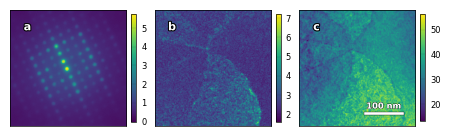

In [6]:
bright_field_ = (150, 162, 152, 165)
dark_field_ = (106,123, 110,125)
printer_ = printer(basepath="./figures/")
filename = "STEM_raw_and_virtual_vortex_walls"
viz.scalebar_ = {'width': 291, 'scale length': 100, 'units': 'nm'}
viz.STEM_raw_and_virtual(vortex, bright_field_=bright_field_, dark_field_=dark_field_, scalebar_=True, filename=filename, shape_ = vortex.data.shape)

## Builds the Neural Network Model

In [7]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:1'

model = ConvAutoencoder(encoder_step_size=encoder_step_size,
                        pooling_list=pooling_list,
                        decoder_step_size=decoder_step_size,
                        upsampling_list=upsampling_list,
                        embedding_size=embedding_size,
                        conv_size=conv_size,
                        device=device,
                        learning_rate=3e-5)

## Trains or Loads Pretrained Weights

In [8]:
# set retrain parameter
train = False

if train:
    model.Train(vortex.log_data,
        coef_1=5e-3,
          coef_2=5e-5,
          coef_3=2e-4,
          epochs=18,
          with_scheduler=False,
          folder_path="Vortex_walls_Weights",
          batch_size=256)
else:
    model.load_weights("/home/ferroelectric/data/11.1_log_epoch_0017_L1loss_0.00181_l1coef_0.0050_lr_0.00009_contrasPara_0.000050_contrasLoss_0.00020_maxiPara_0.00070_maxiLoss_0.0019_trainloss_0.2289.pkl")

## Computes the Embeddings

In [9]:
embedding = model.get_embedding(vortex.log_data)


100%|██████████| 2048/2048 [04:08<00:00,  8.25it/s]


## Visualizes the Embeddings

./figures/Vortex_embedding_maps.png
./figures/Vortex_embedding_maps.svg


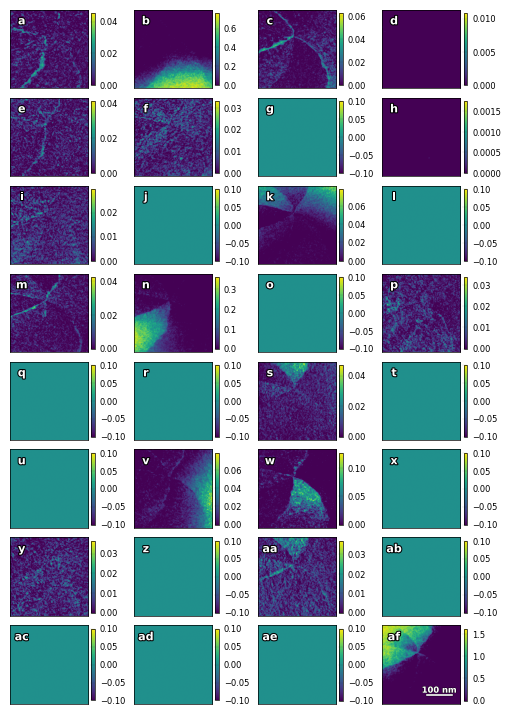

In [11]:
viz.model = model
viz.scalebar_ = {'width': 291, 'scale length': 100, 'units': 'nm'}
viz.embeddings(mod = 4, scalebar_=True, figsize = (5, 8), name = "Vortex_walls", shape_=vortex.data.shape)

In [12]:
model.embedding = embedding
viz.model = model
viz.channels = [0,2]
ranges=[[0,0.025],[0,0.04]]
folder_name = 'Generator_of_Figure_4_e_f_vortex_walls'

viz.generator_images(ranges = ranges, folder_name = folder_name, figsize=(5, 1.25), cbar_number_format = "%d", shape_=vortex.data.shape, divider_ = False)

  0%|          | 0/200 [00:00<?, ?it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0000_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0000_maps.svg


  0%|          | 1/200 [00:00<03:17,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0001_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0001_maps.svg


  1%|          | 2/200 [00:01<03:10,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0002_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0002_maps.svg


  2%|▏         | 3/200 [00:02<03:09,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0003_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0003_maps.svg


  2%|▏         | 4/200 [00:03<03:06,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0004_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0004_maps.svg


  2%|▎         | 5/200 [00:04<03:04,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0005_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0005_maps.svg


  3%|▎         | 6/200 [00:05<03:02,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0006_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0006_maps.svg


  4%|▎         | 7/200 [00:06<03:01,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0007_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0007_maps.svg


  4%|▍         | 8/200 [00:07<03:00,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0008_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0008_maps.svg


  4%|▍         | 9/200 [00:08<02:59,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0009_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0009_maps.svg


  5%|▌         | 10/200 [00:09<02:58,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0010_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0010_maps.svg


  6%|▌         | 11/200 [00:10<03:12,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0011_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0011_maps.svg


  6%|▌         | 12/200 [00:11<03:07,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0012_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0012_maps.svg


  6%|▋         | 13/200 [00:12<03:02,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0013_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0013_maps.svg


  7%|▋         | 14/200 [00:13<02:59,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0014_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0014_maps.svg


  8%|▊         | 15/200 [00:14<02:57,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0015_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0015_maps.svg


  8%|▊         | 16/200 [00:15<02:55,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0016_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0016_maps.svg


  8%|▊         | 17/200 [00:16<02:53,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0017_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0017_maps.svg


  9%|▉         | 18/200 [00:17<02:52,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0018_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0018_maps.svg


 10%|▉         | 19/200 [00:18<02:50,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0019_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0019_maps.svg


 10%|█         | 20/200 [00:19<02:49,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0020_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0020_maps.svg


 10%|█         | 21/200 [00:20<02:48,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0021_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0021_maps.svg


 11%|█         | 22/200 [00:20<02:47,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0022_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0022_maps.svg


 12%|█▏        | 23/200 [00:22<02:58,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0023_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0023_maps.svg


 12%|█▏        | 24/200 [00:23<02:54,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0024_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0024_maps.svg


 12%|█▎        | 25/200 [00:24<02:50,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0025_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0025_maps.svg


 13%|█▎        | 26/200 [00:24<02:47,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0026_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0026_maps.svg


 14%|█▎        | 27/200 [00:25<02:46,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0027_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0027_maps.svg


 14%|█▍        | 28/200 [00:26<02:43,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0028_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0028_maps.svg


 14%|█▍        | 29/200 [00:27<02:41,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0029_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0029_maps.svg


 15%|█▌        | 30/200 [00:28<02:39,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0030_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0030_maps.svg


 16%|█▌        | 31/200 [00:29<02:38,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0031_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0031_maps.svg


 16%|█▌        | 32/200 [00:30<02:36,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0032_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0032_maps.svg


 16%|█▋        | 33/200 [00:31<02:35,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0033_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0033_maps.svg


 17%|█▋        | 34/200 [00:32<02:34,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0034_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0034_maps.svg


 18%|█▊        | 35/200 [00:33<02:33,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0035_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0035_maps.svg


 18%|█▊        | 36/200 [00:34<02:32,  1.07it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0036_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0036_maps.svg


 18%|█▊        | 37/200 [00:35<02:45,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0037_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0037_maps.svg


 19%|█▉        | 38/200 [00:36<02:39,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0038_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0038_maps.svg


 20%|█▉        | 39/200 [00:37<02:36,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0039_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0039_maps.svg


 20%|██        | 40/200 [00:38<02:34,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0040_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0040_maps.svg


 20%|██        | 41/200 [00:39<02:32,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0041_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0041_maps.svg


 21%|██        | 42/200 [00:40<02:31,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0042_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0042_maps.svg


 22%|██▏       | 43/200 [00:41<02:30,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0043_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0043_maps.svg


 22%|██▏       | 44/200 [00:42<02:29,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0044_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0044_maps.svg


 22%|██▎       | 45/200 [00:43<02:27,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0045_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0045_maps.svg


 23%|██▎       | 46/200 [00:43<02:26,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0046_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0046_maps.svg


 24%|██▎       | 47/200 [00:44<02:25,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0047_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0047_maps.svg


 24%|██▍       | 48/200 [00:45<02:24,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0048_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0048_maps.svg


 24%|██▍       | 49/200 [00:46<02:23,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0049_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0049_maps.svg


 25%|██▌       | 50/200 [00:47<02:22,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0050_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0050_maps.svg


 26%|██▌       | 51/200 [00:48<02:21,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0051_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0051_maps.svg


 26%|██▌       | 52/200 [00:49<02:20,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0052_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0052_maps.svg


 26%|██▋       | 53/200 [00:50<02:19,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0053_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0053_maps.svg


 27%|██▋       | 54/200 [00:51<02:18,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0054_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0054_maps.svg


 28%|██▊       | 55/200 [00:52<02:31,  1.05s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0055_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0055_maps.svg


 28%|██▊       | 56/200 [00:53<02:26,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0056_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0056_maps.svg


 28%|██▊       | 57/200 [00:54<02:22,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0057_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0057_maps.svg


 29%|██▉       | 58/200 [00:55<02:19,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0058_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0058_maps.svg


 30%|██▉       | 59/200 [00:56<02:16,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0059_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0059_maps.svg


 30%|███       | 60/200 [00:57<02:14,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0060_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0060_maps.svg


 30%|███       | 61/200 [00:58<02:13,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0061_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0061_maps.svg


 31%|███       | 62/200 [00:59<02:11,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0062_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0062_maps.svg


 32%|███▏      | 63/200 [01:00<02:10,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0063_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0063_maps.svg


 32%|███▏      | 64/200 [01:01<02:09,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0064_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0064_maps.svg


 32%|███▎      | 65/200 [01:02<02:07,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0065_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0065_maps.svg


 33%|███▎      | 66/200 [01:03<02:07,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0066_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0066_maps.svg


 34%|███▎      | 67/200 [01:04<02:06,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0067_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0067_maps.svg


 34%|███▍      | 68/200 [01:05<02:05,  1.06it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0068_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0068_maps.svg


 34%|███▍      | 69/200 [01:06<02:04,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0069_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0069_maps.svg


 35%|███▌      | 70/200 [01:07<02:04,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0070_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0070_maps.svg


 36%|███▌      | 71/200 [01:08<02:02,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0071_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0071_maps.svg


 36%|███▌      | 72/200 [01:09<02:02,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0072_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0072_maps.svg


 36%|███▋      | 73/200 [01:09<02:01,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0073_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0073_maps.svg


 37%|███▋      | 74/200 [01:10<02:00,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0074_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0074_maps.svg


 38%|███▊      | 75/200 [01:11<01:59,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0075_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0075_maps.svg


 38%|███▊      | 76/200 [01:12<01:58,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0076_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0076_maps.svg


 38%|███▊      | 77/200 [01:14<02:12,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0077_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0077_maps.svg


 39%|███▉      | 78/200 [01:15<02:06,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0078_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0078_maps.svg


 40%|███▉      | 79/200 [01:16<02:02,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0079_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0079_maps.svg


 40%|████      | 80/200 [01:17<01:59,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0080_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0080_maps.svg


 40%|████      | 81/200 [01:17<01:56,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0081_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0081_maps.svg


 41%|████      | 82/200 [01:18<01:54,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0082_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0082_maps.svg


 42%|████▏     | 83/200 [01:19<01:52,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0083_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0083_maps.svg


 42%|████▏     | 84/200 [01:20<01:51,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0084_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0084_maps.svg


 42%|████▎     | 85/200 [01:21<01:50,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0085_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0085_maps.svg


 43%|████▎     | 86/200 [01:22<01:48,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0086_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0086_maps.svg


 44%|████▎     | 87/200 [01:23<01:47,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0087_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0087_maps.svg


 44%|████▍     | 88/200 [01:24<01:46,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0088_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0088_maps.svg


 44%|████▍     | 89/200 [01:25<01:45,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0089_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0089_maps.svg


 45%|████▌     | 90/200 [01:26<01:44,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0090_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0090_maps.svg


 46%|████▌     | 91/200 [01:27<01:43,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0091_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0091_maps.svg


 46%|████▌     | 92/200 [01:28<01:42,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0092_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0092_maps.svg


 46%|████▋     | 93/200 [01:29<01:41,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0093_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0093_maps.svg


 47%|████▋     | 94/200 [01:30<01:40,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0094_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0094_maps.svg


 48%|████▊     | 95/200 [01:31<01:40,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0095_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0095_maps.svg


 48%|████▊     | 96/200 [01:32<01:39,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0096_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0096_maps.svg


 48%|████▊     | 97/200 [01:33<01:38,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0097_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0097_maps.svg


 49%|████▉     | 98/200 [01:34<01:37,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0098_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0098_maps.svg


 50%|████▉     | 99/200 [01:35<01:36,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0099_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0099_maps.svg


 50%|█████     | 100/200 [01:36<01:35,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0100_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0100_maps.svg


 50%|█████     | 101/200 [01:37<01:34,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0101_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0101_maps.svg


 51%|█████     | 102/200 [01:37<01:33,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0102_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0102_maps.svg


 52%|█████▏    | 103/200 [01:38<01:32,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0103_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0103_maps.svg


 52%|█████▏    | 104/200 [01:39<01:31,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0104_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0104_maps.svg


 52%|█████▎    | 105/200 [01:41<01:44,  1.10s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0105_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0105_maps.svg


 53%|█████▎    | 106/200 [01:42<01:39,  1.06s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0106_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0106_maps.svg


 54%|█████▎    | 107/200 [01:43<01:35,  1.03s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0107_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0107_maps.svg


 54%|█████▍    | 108/200 [01:44<01:32,  1.00s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0108_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0108_maps.svg


 55%|█████▍    | 109/200 [01:45<01:29,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0109_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0109_maps.svg


 55%|█████▌    | 110/200 [01:46<01:27,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0110_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0110_maps.svg


 56%|█████▌    | 111/200 [01:47<01:26,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0111_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0111_maps.svg


 56%|█████▌    | 112/200 [01:47<01:24,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0112_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0112_maps.svg


 56%|█████▋    | 113/200 [01:48<01:23,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0113_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0113_maps.svg


 57%|█████▋    | 114/200 [01:49<01:22,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0114_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0114_maps.svg


 57%|█████▊    | 115/200 [01:50<01:21,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0115_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0115_maps.svg


 58%|█████▊    | 116/200 [01:51<01:20,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0116_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0116_maps.svg


 58%|█████▊    | 117/200 [01:52<01:19,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0117_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0117_maps.svg


 59%|█████▉    | 118/200 [01:53<01:18,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0118_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0118_maps.svg


 60%|█████▉    | 119/200 [01:54<01:17,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0119_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0119_maps.svg


 60%|██████    | 120/200 [01:55<01:16,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0120_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0120_maps.svg


 60%|██████    | 121/200 [01:56<01:15,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0121_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0121_maps.svg


 61%|██████    | 122/200 [01:57<01:14,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0122_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0122_maps.svg


 62%|██████▏   | 123/200 [01:58<01:13,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0123_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0123_maps.svg


 62%|██████▏   | 124/200 [01:59<01:12,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0124_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0124_maps.svg


 62%|██████▎   | 125/200 [02:00<01:11,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0125_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0125_maps.svg


 63%|██████▎   | 126/200 [02:01<01:10,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0126_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0126_maps.svg


 64%|██████▎   | 127/200 [02:02<01:09,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0127_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0127_maps.svg


 64%|██████▍   | 128/200 [02:03<01:08,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0128_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0128_maps.svg


 64%|██████▍   | 129/200 [02:04<01:07,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0129_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0129_maps.svg


 65%|██████▌   | 130/200 [02:05<01:06,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0130_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0130_maps.svg


 66%|██████▌   | 131/200 [02:06<01:05,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0131_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0131_maps.svg


 66%|██████▌   | 132/200 [02:07<01:04,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0132_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0132_maps.svg


 66%|██████▋   | 133/200 [02:07<01:03,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0133_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0133_maps.svg


 67%|██████▋   | 134/200 [02:08<01:02,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0134_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0134_maps.svg


 68%|██████▊   | 135/200 [02:09<01:01,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0135_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0135_maps.svg


 68%|██████▊   | 136/200 [02:10<01:00,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0136_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0136_maps.svg


 68%|██████▊   | 137/200 [02:11<00:59,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0137_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0137_maps.svg


 69%|██████▉   | 138/200 [02:12<00:58,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0138_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0138_maps.svg


 70%|██████▉   | 139/200 [02:13<00:58,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0139_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0139_maps.svg


 70%|███████   | 140/200 [02:15<01:08,  1.14s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0140_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0140_maps.svg


 70%|███████   | 141/200 [02:16<01:03,  1.08s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0141_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0141_maps.svg


 71%|███████   | 142/200 [02:17<01:00,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0142_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0142_maps.svg


 72%|███████▏  | 143/200 [02:18<00:57,  1.02s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0143_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0143_maps.svg


 72%|███████▏  | 144/200 [02:19<00:55,  1.00it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0144_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0144_maps.svg


 72%|███████▎  | 145/200 [02:20<00:54,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0145_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0145_maps.svg


 73%|███████▎  | 146/200 [02:20<00:52,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0146_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0146_maps.svg


 74%|███████▎  | 147/200 [02:21<00:51,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0147_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0147_maps.svg


 74%|███████▍  | 148/200 [02:22<00:50,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0148_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0148_maps.svg


 74%|███████▍  | 149/200 [02:23<00:49,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0149_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0149_maps.svg


 75%|███████▌  | 150/200 [02:24<00:47,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0150_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0150_maps.svg


 76%|███████▌  | 151/200 [02:25<00:46,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0151_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0151_maps.svg


 76%|███████▌  | 152/200 [02:26<00:45,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0152_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0152_maps.svg


 76%|███████▋  | 153/200 [02:27<00:44,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0153_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0153_maps.svg


 77%|███████▋  | 154/200 [02:28<00:43,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0154_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0154_maps.svg


 78%|███████▊  | 155/200 [02:29<00:42,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0155_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0155_maps.svg


 78%|███████▊  | 156/200 [02:30<00:41,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0156_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0156_maps.svg


 78%|███████▊  | 157/200 [02:31<00:40,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0157_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0157_maps.svg


 79%|███████▉  | 158/200 [02:32<00:39,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0158_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0158_maps.svg


 80%|███████▉  | 159/200 [02:33<00:38,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0159_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0159_maps.svg


 80%|████████  | 160/200 [02:34<00:38,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0160_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0160_maps.svg


 80%|████████  | 161/200 [02:35<00:37,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0161_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0161_maps.svg


 81%|████████  | 162/200 [02:36<00:36,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0162_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0162_maps.svg


 82%|████████▏ | 163/200 [02:37<00:35,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0163_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0163_maps.svg


 82%|████████▏ | 164/200 [02:38<00:34,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0164_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0164_maps.svg


 82%|████████▎ | 165/200 [02:39<00:33,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0165_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0165_maps.svg


 83%|████████▎ | 166/200 [02:40<00:32,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0166_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0166_maps.svg


 84%|████████▎ | 167/200 [02:40<00:31,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0167_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0167_maps.svg


 84%|████████▍ | 168/200 [02:41<00:30,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0168_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0168_maps.svg


 84%|████████▍ | 169/200 [02:42<00:29,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0169_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0169_maps.svg


 85%|████████▌ | 170/200 [02:43<00:28,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0170_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0170_maps.svg


 86%|████████▌ | 171/200 [02:44<00:27,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0171_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0171_maps.svg


 86%|████████▌ | 172/200 [02:45<00:26,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0172_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0172_maps.svg


 86%|████████▋ | 173/200 [02:46<00:25,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0173_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0173_maps.svg


 87%|████████▋ | 174/200 [02:47<00:24,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0174_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0174_maps.svg


 88%|████████▊ | 175/200 [02:48<00:23,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0175_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0175_maps.svg


 88%|████████▊ | 176/200 [02:49<00:22,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0176_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0176_maps.svg


 88%|████████▊ | 177/200 [02:50<00:21,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0177_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0177_maps.svg


 89%|████████▉ | 178/200 [02:51<00:21,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0178_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0178_maps.svg


 90%|████████▉ | 179/200 [02:52<00:20,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0179_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0179_maps.svg


 90%|█████████ | 180/200 [02:53<00:19,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0180_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0180_maps.svg


 90%|█████████ | 181/200 [02:54<00:18,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0181_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0181_maps.svg


 91%|█████████ | 182/200 [02:55<00:17,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0182_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0182_maps.svg


 92%|█████████▏| 183/200 [02:57<00:20,  1.19s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0183_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0183_maps.svg


 92%|█████████▏| 184/200 [02:57<00:17,  1.12s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0184_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0184_maps.svg


 92%|█████████▎| 185/200 [02:58<00:16,  1.07s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0185_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0185_maps.svg


 93%|█████████▎| 186/200 [02:59<00:14,  1.04s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0186_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0186_maps.svg


 94%|█████████▎| 187/200 [03:00<00:13,  1.01s/it]

./figures/generator_images_Generator_of_Figure_4_e_f/0187_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0187_maps.svg


 94%|█████████▍| 188/200 [03:01<00:11,  1.01it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0188_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0188_maps.svg


 94%|█████████▍| 189/200 [03:02<00:10,  1.02it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0189_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0189_maps.svg


 95%|█████████▌| 190/200 [03:03<00:09,  1.03it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0190_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0190_maps.svg


 96%|█████████▌| 191/200 [03:04<00:08,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0191_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0191_maps.svg


 96%|█████████▌| 192/200 [03:05<00:07,  1.04it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0192_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0192_maps.svg


 96%|█████████▋| 193/200 [03:06<00:06,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0193_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0193_maps.svg


 97%|█████████▋| 194/200 [03:07<00:05,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0194_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0194_maps.svg


 98%|█████████▊| 195/200 [03:08<00:04,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0195_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0195_maps.svg


 98%|█████████▊| 196/200 [03:09<00:03,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0196_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0196_maps.svg


 98%|█████████▊| 197/200 [03:10<00:02,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0197_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0197_maps.svg


 99%|█████████▉| 198/200 [03:11<00:01,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0198_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0198_maps.svg


100%|█████████▉| 199/200 [03:12<00:00,  1.05it/s]

./figures/generator_images_Generator_of_Figure_4_e_f/0199_maps.png
./figures/generator_images_Generator_of_Figure_4_e_f/0199_maps.svg


100%|██████████| 200/200 [03:13<00:00,  1.04it/s]


## Builds a Movie

In [13]:
folder = "./figures/generator_images_Generator_of_Figure_4_e_f_vortex_walls/"
output_folder = "./movies/"

# function to make the movie
make_movie('Vortex Wall Generator',
           folder,
           output_folder,
          'png',
          3)